## Correcting for autocorrelation in regression analyses of neuronal data.

**Thomas Akam 2020**

This notebook explores ways of computing P values in regression analyses of neuronal data which correct for the effect of autocorrelation in behavioural and neuronal time series.  Such autocorrealtions severely overinflate the number of neurons identified as significantly related to behaviour if P values from a standard regression analysis are used, see [Elber-Dorozko & Loewenstein 2018](https://elifesciences.org/articles/34248).

We first generate some simualated behavioural and neuronal activity time series.  Time series with and without autocorrelation are generated.  The uncorrelated time series are are Gaussian white noise. The autocorrelated time series are Guassian white noise filtered with a Gaussian kernel.

Text(0.5, 0, 'Trial number')

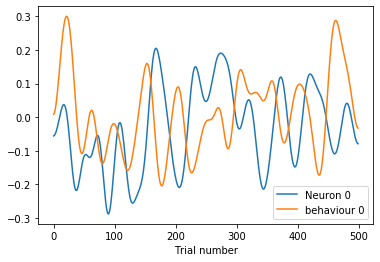

In [1]:
import numpy as np
import pylab as plt
from scipy.ndimage import gaussian_filter1d

n_neurons = 100
n_behaviour = 100
n_trials = 500
smooth_SD = 10

def generate_signals(n_signals, n_trials, smooth_SD):
    # Generate autocorrelated signals by gaussian smoothing white noise.
    x = np.random.randn(n_signals, n_trials)
    if smooth_SD:
        x = gaussian_filter1d(x, smooth_SD, axis=1)
    return x

# Generate signals without autocorrelation.

a_unc = generate_signals(n_neurons  , n_trials, False) # Neuronal activity
b_unc = generate_signals(n_behaviour, n_trials, False) # Behavioural variables

# Generate signals with autocorrelation.

a_cor = generate_signals(n_neurons  , n_trials, smooth_SD) # Neuronal activity
b_cor = generate_signals(n_behaviour, n_trials, smooth_SD) # Behavioural variables

# Plot example autocorrelated signals.

plt.plot(a_cor[0,:], label='Neuron 0')
plt.plot(b_cor[0,:], label='behaviour 0')
plt.legend()
plt.xlabel('Trial number')

First we will run a set of standard linear regressions each predicting a single neuronal time series from a single behaviuoral time series.  We will plot the P values ordered from smallest to largest.  As there is no relationship between the signals the P values should be uniformly distributed between 0 and 1.

In [2]:
from tqdm import tqdm
from sklearn.utils import resample
from scipy.stats import linregress

def linregress_p_value(x,y):
    # Return the P values for a linear regression predicting y using x.
    return linregress(x, y).pvalue

def sorted_P_values(A, B, p_val_func):
    # Calculate P values for each regression predicting a neuronal activity signal A[i,:]
    # using a behavioural signal B[j,:]. P values are computed using the provided p_val_func.
    n_neurons = A.shape[0]
    n_behaviour = B.shape[0]
    p_values = np.zeros([n_neurons, n_behaviour])                        
    for i in tqdm(range(n_neurons)):
        for j in range(n_behaviour):
            p_values[i,j] = p_val_func(B[j,:], A[i,:])
    return np.sort(p_values, axis=None)

def PP_plot(sorted_values, n_boot=5000):
    # Plot the sorted P values against their quantile in blue, with a black line
    # showing a uniform distribution and bootstrap 95% confidence intervals. 
    n = len(sorted_values)
    x = np.arange(1, n+1)/n
    # Evaluate and plot bootstrap 95% confidence interval.
    bs = np.sort(np.sort(np.vstack([resample(sorted_values)
            for _ in range(n_boot)]), axis=1), axis=0)
    plt.fill_between(x, bs[int(0.025*n_boot),:], bs[int(0.975*n_boot),:],
                     color='b', alpha=0.3, lw=0)
    # Plot P values and uniform distribution.
    plt.loglog([x[0],1],[x[0],1], 'k', label='Uniform')
    plt.loglog(x, sorted_values, 'b', label='Empirical')
    plt.xlabel('Quantile')
    plt.ylabel('P value')
    plt.legend()
    plt.xlim([0.001,1])

For the uncorrelated data, P values returned by a standard regression analysis are distributed uniformly between 0 and 1, as expected given the absence of any predictive relationhsip between the time series.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.39it/s]


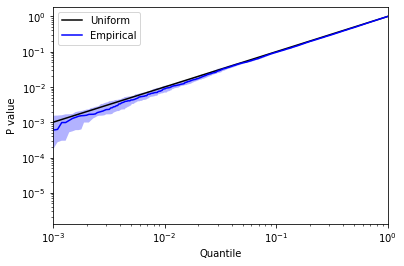

In [3]:
P_values_unc = sorted_P_values(a_unc, b_unc, linregress_p_value)
PP_plot(P_values_unc)

Now let's try on the autocorrelated data...

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


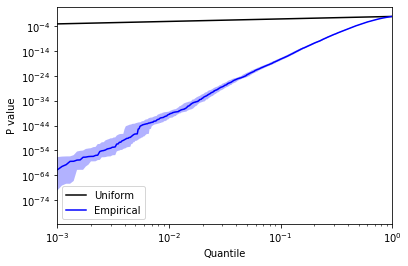

In [4]:
P_values_cor = sorted_P_values(a_cor, b_cor, linregress_p_value)
PP_plot(P_values_cor)

Yikes!  Due to autocorrelation of the signals, naively using P values obtained from a standard regression analysis suggest that overwhelmingly significant preditive relationships exist between almost all behaviour and neuronal time series despite the lack of any actual relationship. 

### Circular shift permutation test

Now lets calculate P values using a permutation test which preserves the autocorrelation in both time series but randomises the relationship between them using circular shifts of behaviour relative to neuronal activity.

In [5]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()

def circ_shift_P_value(x, y):
    # Calculate the P value for a linear regression predicting y using x by comparing
    # the beta weight for the real data with the distribution of beta weights over an
    # ensemble of datasets obtained by circularly shifing one of the time series.
    # This function computes the distribution using all possible circular shifts.
    ols.fit(x.reshape(-1, 1),y.reshape(-1, 1))
    true_beta = ols.coef_[0,0]
    circ_shift_y = np.vstack([np.roll(y,s) for s in range(len(y))])
    ols.fit(x.reshape(-1, 1),circ_shift_y.T)
    perm_betas = ols.coef_
    p_value = 2*np.min([np.mean(perm_betas>true_beta), np.mean(perm_betas<true_beta)]) 
    return p_value

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


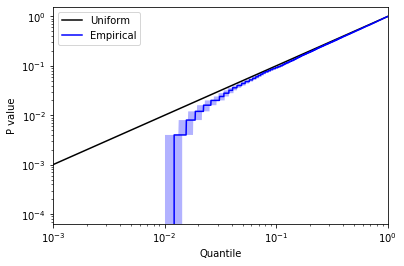

In [6]:
circ_shift_P_values = sorted_P_values(a_cor, b_cor, circ_shift_P_value)
        
PP_plot(circ_shift_P_values)
    

The distribution looks much better than that obtained by naively using the P values returned by a standard regression analysis. However, this permuation test does still inflate the number of small P values, probably due to the discontinuity between the start and end of the session which means that the distribution of the permuted data does not exactly match that the true data is drawn from.  The P values change in discrete steps because the maximum number of different permutations that can be done for a given neuron-behaviour pair is limited by the number of trials (500 here).




### Fourier phase randomisation permutation test

Now lets try an alternative approach to generated permuted datasets where we randomise the phase of each Fourier coefficient of one of the signals.  First we will show what phase randomisation does to one of our simulated time series.

Text(0.5, 1.0, 'Amplitude spectra')

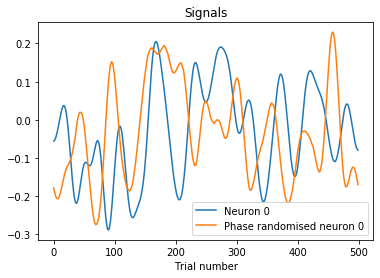

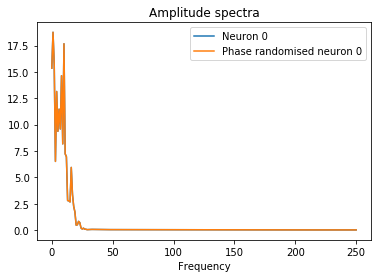

In [7]:
def randomise_phase(x):
    # Randomise the Fourier phases of 1D signal x while keeping the amplitudes constant.
    fft = np.fft.rfft(x)
    fft_amp = np.abs(fft)
    fft_ang = np.angle(fft)
    if len(x)%2 == 0:  # Even length, first and last fft elements are real valued.
        fft_ang[1:-1] = np.random.rand(len(fft)-2)*2*np.pi
    else: # Odd length, first fft element is real valued.
        fft_ang[1:] = np.random.rand(len(fft)-1)*2*np.pi
    prfft = fft_amp*np.cos(fft_ang)+1j*fft_amp*np.sin(fft_ang)
    return np.fft.irfft(prfft,len(x))

# Plot example signal and a phase randomised version of it. 

x = a_cor[0,:]
x_pr = randomise_phase(a_cor[0,:])

plt.plot(x, label='Neuron 0')
plt.plot(x_pr, label='Phase randomised neuron 0')
plt.xlabel('Trial number')
plt.legend()
plt.title('Signals')

plt.figure()
plt.plot(np.abs(np.fft.rfft(x)),label='Neuron 0')
plt.plot(np.abs(np.fft.rfft(x_pr)),label='Phase randomised neuron 0')
plt.xlabel('Frequency')
plt.legend()
plt.title('Amplitude spectra')

Now we compute P values using a permutation test using phase randomisation.

In [8]:
def phase_shift_P_value(x, y, n_perm=5000):
    # Calculate the P value for a linear regression predicting y using x by comparing the 
    # absolute value of the regression coefficient obtained on the real data with the
    # distribution of absolute values obtained by running the regression analysis on an 
    # ensemble of datasets obtained by randomising the fourier phase of one of the time series.
    ols.fit(x.reshape(-1, 1),y.reshape(-1, 1))
    true_beta = ols.coef_[0,0]
    phase_shift_y = np.vstack([randomise_phase(y) for _ in range(n_perm)])
    ols.fit(x.reshape(-1, 1), phase_shift_y.T)
    perm_betas = ols.coef_
    p_value = 2*np.min([np.mean(perm_betas>true_beta), np.mean(perm_betas<true_beta)]) 
    return p_value

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:04:50<00:00, 38.91s/it]


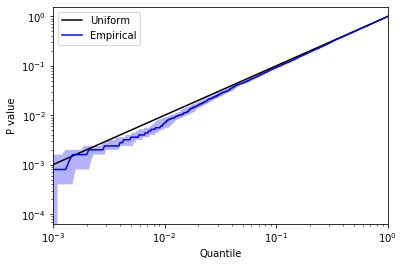

In [21]:
phase_shift_P_values = sorted_P_values(a_cor, b_cor, phase_shift_P_value)
        
PP_plot(phase_shift_P_values)

The distribution looks pretty good, it is close to uniform over most of the range of P values, but appears to somewhat overinflate the number of small P values.

We will expore two possible reasons why the P values do not appear to be completely uniformly distributed. The first is the discontinuity between the start and end of the session, which is present in the original signals but not in the phase permuted signals.  These edge effects are looked at for both permutation tests below.

Annother possibility is that if the phase relationships between frequencies are not random in the raw signals, e.g. due to the presence of harmonics, randomising Fourier phase may not be an appropriate permutation as it will break this correlation structure between frequences.  To test this lets create some signals where the phases at different frequencies are strongly non-independent due the the presence of sharp transitions between binary levels.

Text(0.5, 0, 'Trial number')

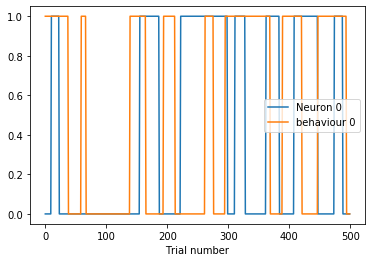

In [10]:
# Generate autocorrelated binary signals.

a_bin = (a_cor > 0).astype(float) # Neuronal activity
b_bin = (b_cor > 0).astype(float) # Behavioural variables

# Plot example signals.

plt.plot(a_bin[0,:], label='Neuron 0')
plt.plot(b_bin[0,:], label='behaviour 0')
plt.legend()
plt.xlabel('Trial number')

Unlike with the previous signals, randomising Fourier phases makes these signals look very different:

Text(0.5, 1.0, 'Signals')

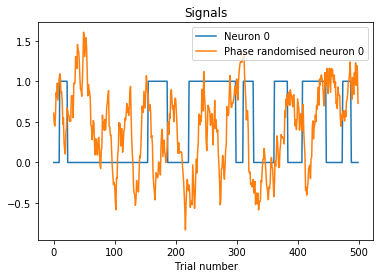

In [11]:
x = a_bin[0,:] # Example signal
x_pr = randomise_phase(x) # Phase randomised example signal.

plt.plot(x, label='Neuron 0')
plt.plot(x_pr, label='Phase randomised neuron 0')
plt.xlabel('Trial number')
plt.legend()
plt.title('Signals')


Does the Fourier phase randomisation permutation test still give sensible P values when applied to these binary signals?

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:01:24<00:00, 36.85s/it]


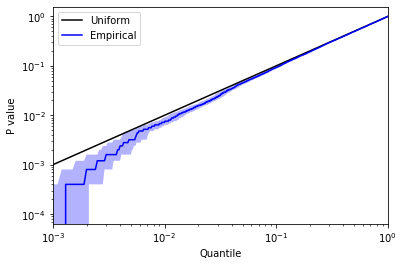

In [12]:
phase_shift_P_values_bin = sorted_P_values(a_bin, b_bin, phase_shift_P_value)
        
PP_plot(phase_shift_P_values_bin)

It looks like with these binary signals the Fourier phase randomisation permutation test is works slighly less well than on the Gaussian filtered white noise. This suggests that correlation between phases at different frequencies (e.g. due to harmonics) may cause phase randomisation to be slightly under conservative, however see further simulations below.

### Edge effects

To test whether it is really the discontinuity between the begining and end of the session which is causing permutation test P values to systematically deviate from a uniform distribution, we can take advantage of the fact that the phase randomised signals are circular - i.e. the start and end have the same values.

Text(0.5, 1.0, 'Circular signal')

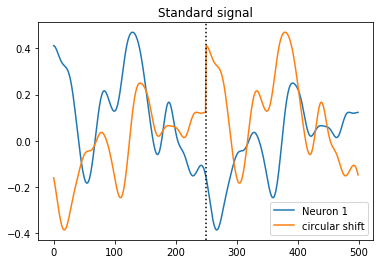

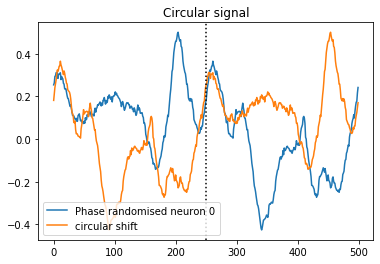

In [25]:
x = a_cor[1,:]
x_shift = np.roll(x,250)

plt.plot(x, label='Neuron 1')
plt.plot(x_shift,label='circular shift' )
plt.axvline(250, color='k', linestyle=':')
plt.legend()
plt.title('Standard signal')

x_pr = randomise_phase(a_cor[1,:])
x_pr_shift = np.roll(x_pr,250)

plt.figure()
plt.plot(x_pr, label='Phase randomised neuron 0')
plt.plot(x_pr_shift,label='circular shift' )
plt.axvline(250, color='k', linestyle=':')
plt.legend(loc='lower left')
plt.title('Circular signal')


Using phase randomisation, we will generate a set of circular signals (i.e. signals where the start and end of the session have the same value).  We can then run the permutation tests on them.  If edge effects were causing the P values to deviate from a uniform distribution, the permutation tests should give a uniform distribution on these circular signals.

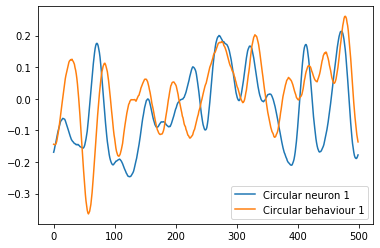

In [14]:
a_cir = np.vstack([randomise_phase(a_cor[i,:]) for i in range(n_neurons)])
b_cir = np.vstack([randomise_phase(b_cor[i,:]) for i in range(n_behaviour)])

plt.plot(a_cir[0,:], label='Circular neuron 1')
plt.plot(b_cir[0,:], label='Circular behaviour 1')
plt.legend()

First we run the circular shift permutation test

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


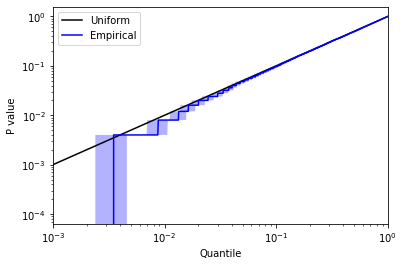

In [15]:
circ_shift_P_values_cir = sorted_P_values(a_cir, b_cir, circ_shift_P_value)
        
PP_plot(circ_shift_P_values_cir)

P values computed usign the circular shift method are very close to uniformly distributed for these circular signals, confirming that it is the discontinuity between start and end of session that caused the error. The drop off at the bottom happens because with 500 permutations the test cannot generage any intermediate P values between 0.002 and 0.

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:01:47<00:00, 37.08s/it]


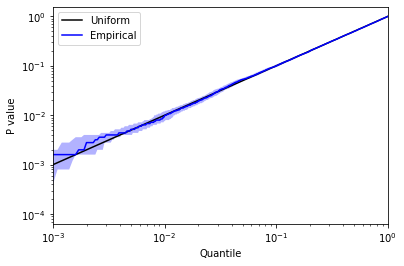

In [16]:
phase_shift_P_values_cir = sorted_P_values(a_cir, b_cir, phase_shift_P_value)
        
PP_plot(phase_shift_P_values_cir)

The phase randomisation permutation test also gives P values that are uniformly distributed.  However, the signals we obtain using phase randomisation are not great control data for testing the phase randomisation permutation test, as by construction they come from the same distribution as that used for the permutations.  Lets try binarising the circular signals, to ensure they are drawn from a different distribution then running the phase randomisation test.

Text(0.5, 0, 'Trial number')

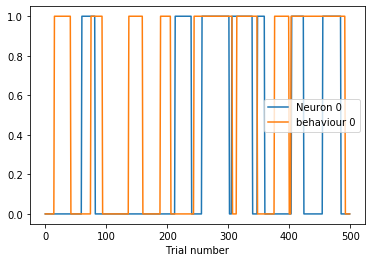

In [17]:
# Generate autocorrelated binary signals.

a_cbn = (a_cir > 0).astype(float) # Neuronal activity
b_cbn = (b_cir > 0).astype(float) # Behavioural variables

# Plot example signals.

plt.plot(a_cbn[0,:], label='Neuron 0')
plt.plot(b_cbn[0,:], label='behaviour 0')
plt.legend()
plt.xlabel('Trial number')

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:01:24<00:00, 36.85s/it]


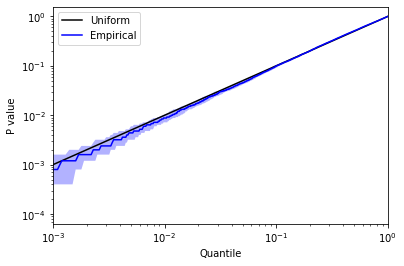

In [18]:
phase_shift_P_values_cbn = sorted_P_values(a_cbn, b_cbn, phase_shift_P_value)
        
PP_plot(phase_shift_P_values_cbn)

Again the phase randomisation permuation test is generating p values that are very close to uniform.  This suggests that the deviation we saw with the binary signals earlier is due to the discontinuity between start and end of session, not simply correlation between phases at different frequncies induced by the sharp transitions in the signal.

Overall, permutation tests using Fourier phase randomisation appears to be a good way to generate P values for regression analyses with autocorellated signals, though they can be slightly underconservative due to the discontinuity between the start and end of the signals.

### Regression with autoregressive model

Rather than using permutation based statistics, can we fix the problems using a regression model which explicitly models the autocorrelation?

First try a basic autoregressive model which inlcudes prior lags of y as predictors but does not model the residuals as autocorrelated.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


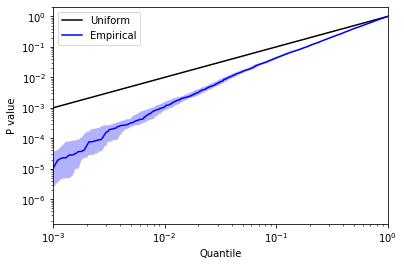

In [19]:
from statsmodels.tsa.ar_model import AutoReg

def AR_model_p_value(x,y):
    return AutoReg(y, lags=50, exog=x).fit().pvalues[-1]

AR_P_values = sorted_P_values(a_cor, b_cor, AR_model_p_value)
        
PP_plot(AR_P_values)


This model gives massively overinflated P values, presumably due to not modelling autocorrelation in the residuals.  The next step is try using an ARMA model which assumes autocorrelated residuals.

In [26]:
from statsmodels.tsa.arima_model import ARMA

def ARMA_p_value(x,y):
    return ARMA(y, order=(1,1), exog=x).fit().pvalues[1]

ARMA_P_values = sorted_P_values(a_cor, b_cor, ARMA_p_value)
        
PP_plot(ARMA_P_values)

Attempting to fit this ARMA model is giving an error:
```
ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
```